times ATTREX+POSIDON+CONTRAST
times Frzproc
times Frzproc-Obs


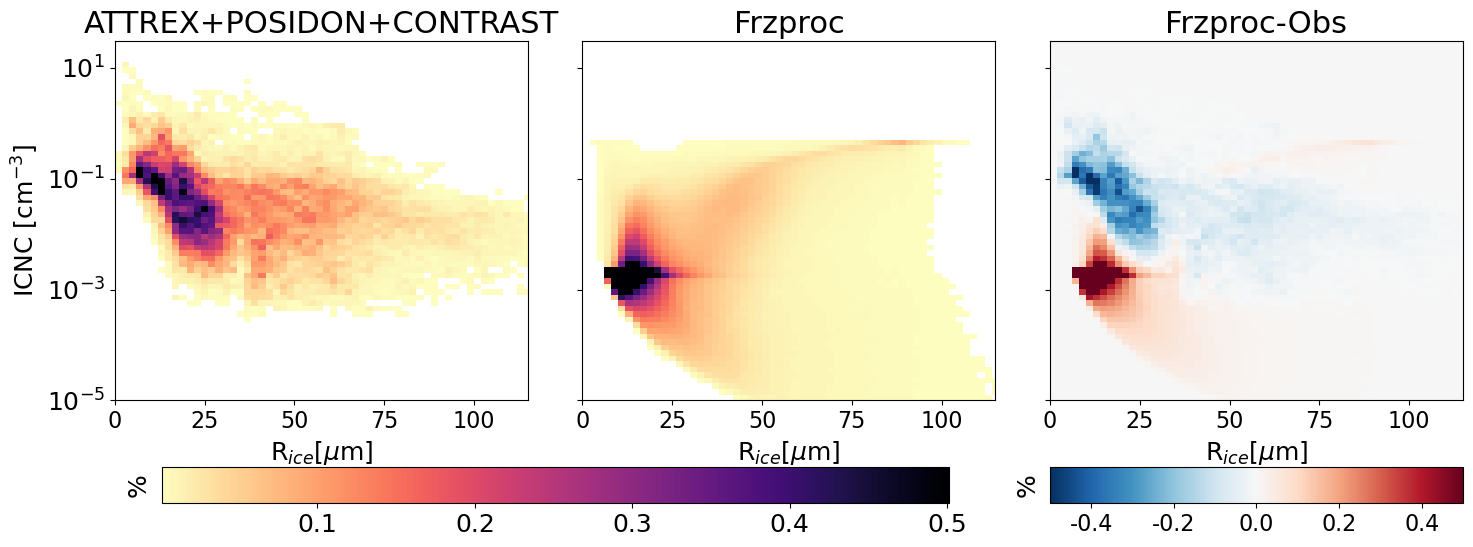

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import ticker
import xarray as xr
import copy
#make path to the module active
import sys
sys.path.append('/glade/u/home/blazg/scripts/modules_python/')
import sam #for module ncopen


timeind= slice(None) #slice(0,200,1)#
levind = slice(None)
lonind = slice(None)

path = '/glade/campaign/univ/uwas0108/blazg/obs_data/cirrus-guideII-database/processed/'
path2='/glade/scratch/sturbeville/DPSCREAM_simulations/'
run='ch'
savepath = '/glade/u/home/sturbeville/DP_diagnostics/notebooks/plots/'

xbox2=1.05
ybox2=-0.01
padbox2=1.5


abc = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v']
xbox=0.9
ybox=0.97
padbox=2.2

###############################################################################

def calc_rice(qi, ni):
    rho = 920 # kg/m3
    qi = qi # kg/kg
    ni =  ni # 1/kg
    r_ice = np.where((ni>1e-5),(3*qi/(4*np.pi*rho*ni))**(1/3),0)*1e6 # um
    return r_ice


def calc_ni(numice, qv,p,t):
    ni = numice * calc_rho(qv,p,t)  # 1/kg * kg/m3 = 1/m3
    return ni

def calc_rho(qv, p, t):
    """calculates density of air in kg/m3 for given input"""
    R =  287 # (Gas constant of air) J/(kg*K)
    Tv = (1 + 0.61*qv) * t # K
    rho = p / (R*Tv) # kg/m3
    return rho

###############################################################################   

simulations = ['ATTREX+POSIDON+CONTRAST','Frzproc','Frzproc-Obs']
label = simulations

xbox2=0.85
ybox2=0.95
ybox2b=1.01

varnames3d = ['binned in-cloud ice crystal radius',\
              'ice radius','ice number concentration']
#ALL_microguideII_tbinned_iwc_icnc_rad.nc
#data_3d = sam.ncopen(path+'ATT_POS_microguideII_tbinned_iwc_icnc_rad_2.nc',varnames3d,ind=timeind)
# data_3d = sam.ncopen(path+'ATT_POS_CONT_microguideII_iwc_vs_icnc_Tless-40.nc',varnames3d,ind=timeind)
data_3d = xr.open_dataset(path+'ATT_POS_CONT_microguideII_iwc_vs_icnc_Tless-40_runningmean18x.nc')

#daily mean
#iwc=data_3d['binned in-cloud iwc'].squeeze() #in g/m3
#icnc=data_3d['binned in-cloud icnc'].squeeze() #in g/kg
reffi=data_3d['binned in-cloud ice crystal radius'].squeeze() #in micron

#xice = data_3d['ice water content'].squeeze() #in g/m3
xrad=data_3d['ice radius'].squeeze() #in g/m3
xnum=data_3d['ice number concentration'].squeeze() #in number/cm3

ds = xr.open_dataset(path2+'scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc'.format(run,run))
# data_3d_4 = sam.ncopen(path2+'ICNCvsREI_Walker3D_1km_frzproc_qi1e-5_Tless-40.nc',varnames3d,ind=timeind)
#data_3d_4 = sam.ncopen(path+'tbinned_test_1Cat_nfrz_rei_vs_icnc_Tless-40.nc',varnames3d,ind=timeind)


#iwc2=data_3d_4['binned in-cloud iwc'].squeeze() #in g/m3
#icnc2=data_3d_4['binned in-cloud icnc'].squeeze() #in g/kg
# reffi2=data_3d_4['binned in-cloud ice crystal radius'].squeeze() #in micron
rice = calc_rice(ds.CLDICE, ds.NUMICE)
ni = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T'])
xbins = np.arange(0,141,2)
ybins = 10**np.linspace(-5,2,71) 
x_array = rice.flatten() # .where(ds["T"]<243.15).where(ds.CLDICE>qsmall).where(ds.lev<150)
y_array = ni.where(ds["T"]<233.15).where(ds.CLDICE>1e-8).values.flatten()/1e6 #. # convert to cm-3
# y_array = np.where(x_array>1e-9, np.where(y_array>1e-9,y_array,np.nan), np.nan)
x_array = x_array[~np.isnan(y_array)]
y_array = y_array[~np.isnan(y_array)]
hist_counts = np.histogram2d(x_array, y_array, bins=[xbins,ybins], normed=False)[0]
reffi2 = hist_counts.T


cmap_list = ['magma_r','magma_r',\
             'magma_r','RdBu_r','viridis','viridis_r']

ybins = 10**np.linspace(-5,2,71)
#ybins = ybins -273.15
yax =(ybins[:-1]+ybins[1:])/2.
#yax =yax[::-1]

med0 = np.zeros((3,len(ybins)-1))
med1 = np.zeros((3,len(ybins)-1))
############################################################################

############################################################################

plt.close() #so that the previous plots don't mess up with current plotting
plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
gs = gridspec.GridSpec(3,30,height_ratios=[1,0.035,0.1],width_ratios=30*[1])

fig5 = plt.figure()
fig5.set_size_inches(18,6,forward=True)


xaxis_list = xrad
labels = ['R$_{ice}$[$\mu$m]']
procname=['Rice']

norm_temp = np.zeros((3,1,len(ybins)-1,len(xrad)))
varnorm = np.zeros((3,1,len(ybins)-1,len(xrad)))

for s, simul in enumerate(simulations):
    print('times',simulations[s])

 ###############################################################       
    #fact=np.sum(iwc_counts[0])/np.sum(iwc_counts[1])
    xplot=[0,10,20,30,40,50]
    xplot2=[9,19,29,39,49,59]
    if s==0:
        wvar_list = (reffi/np.sum(reffi))        
    if s==1:
        wvar_list = (reffi2/np.sum(reffi2))     
    if s==2:
        yplot=[0,0,0,0,0,0]
        
        wvar_list = (reffi2/np.sum(reffi2)-reffi/np.sum(reffi))

        

    xax = xrad
        
    ax = fig5.add_subplot(gs[0,xplot[s]:xplot2[s]])
    

    plotvar=wvar_list[:,:]
   

        #allcounts_sum_ma = np.ma.masked_array(plotvar, plotvar < 1e-5)

    if s<2:
            ############statistics#- consistent with caliop###########################  
            #med = np.zeros((len(ybins)-1))
            #mean = np.zeros((len(ybins)-1))
            
            norm = np.nansum(plotvar)
            varnorm[s,0] = plotvar/norm
            varnorm[varnorm<1e-5] = np.nan
    

            #CS2=ax.pcolormesh(xax,yax,norm_temp[s,v]*100,cmap=plt.cm.magma_r,vmin=1e-1,vmax=10) #in %
            CS2=ax.pcolormesh(xax,yax,varnorm[s,0]*100,cmap=plt.cm.magma_r,vmin=1e-3,vmax=0.501) #in %
            
    if s==2:
            varnorm[np.isnan(varnorm)] = 0 #avoid weird stuff
            CS2=ax.pcolormesh(xax,yax,100*(varnorm[1,0]-varnorm[0,0]),\
                              cmap=plt.cm.RdBu_r,norm=colors.Normalize(vmin=-0.5, vmax=0.5))
            #plt.plot(med0[v][::-1],(ybins[:-1]+ybins[1:])/2.,color='g',linewidth=4)
            #plt.plot(med1[v][::-1],(ybins[:-1]+ybins[1:])/2.,color='dodgerblue',linewidth=4)        
            
    ax.tick_params(axis='both',which='both',labelbottom='on')
    tt = plt.title(simulations[s], fontsize=22)
    tt.set_y(1.01)
            
    #plt.text(xbox2,ybox2,procname,transform=ax.transAxes,horizontalalignment='left',
    #verticalalignment='top',fontsize=18,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=padbox))

            
    plt.xticks(size=16)
    plt.xlabel(labels[0],size=18)  
    plt.ylim([1e-5,30])
    plt.xlim(0,115)
    plt.yscale('log')
            
    if s==0:
            #plt.ylabel('ICNC')
            plt.ylabel('ICNC [cm$^{-3}$]')#,size=15)
            


    if (s>0):
            ax.tick_params(
                axis='both',        
                which='both',      # both major and minor ticks are affected
                labelleft=False)
            
    if s==1:
            cax1 = fig5.add_subplot(gs[2,1:18])
            cb = plt.colorbar(CS2,cax=cax1,orientation='horizontal',format='%1.1f')
            #cb.set_label(labels[v],fontsize=14)
            cb.ax.tick_params(labelsize=18)
            plt.ylabel('%')
            
            
    
    if ((s==2)):
            cax1 = fig5.add_subplot(gs[2,20:29])
            cb = plt.colorbar(CS2,cax=cax1,orientation='horizontal',format='%1.1f')
            #cb.set_label(labels[v],fontsize=14)
            cb.ax.tick_params(labelsize=16)  
            tick_locator = ticker.MaxNLocator(nbins=5)
            cb.locator = tick_locator
            cb.update_ticks()
            plt.ylabel('%')#,size=15)
        #plt.text(xbox,ybox,abc[num],transform=ax.transAxes,horizontalalignment='left',
        #verticalalignment='top',fontsize=20,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=padbox))
        
plt.savefig('plots/obs_model_icnc_rei_space_{}.png'.format(run),dpi=200,bbox_inches='tight')

plt.show(block=False)

In [ ]:
#  

times Standard


ValueError: could not broadcast input array from shape (70,70) into shape (70,71)

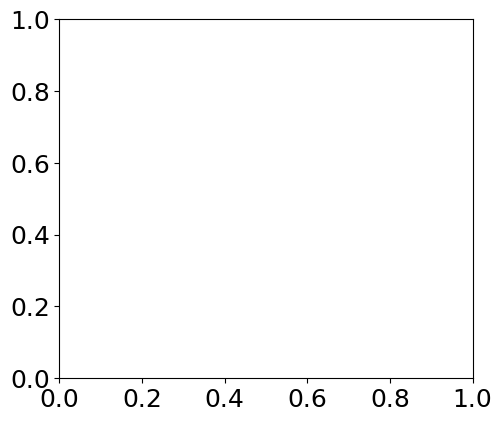

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import ticker
import xarray as xr
#make path to the module active
# import sys
# sys.path.append('/glade/u/home/blazg/scripts/modules_python/')
# import sam #for module ncopen


timeind= slice(None) #slice(0,200,1)#
levind = slice(None)
lonind = slice(None)

path = '/glade/scratch/sturbeville/DPSCREAM_simulations/'
savepath = '/glade/u/home/sturbeville/scmlib/DP_diagnostics/notebooks/plots/'

xbox2=1.05
ybox2=-0.01
padbox2=1.5


abc = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v']
xbox=0.9
ybox=0.97
padbox=2.2

#############################################################################

###############################################################################

def calc_rice(qi, ni):
    rho = 920 # kg/m3
    qi = qi # kg/kg
    ni =  ni # 1/kg
    r_ice = np.where((ni>1e-5),(3*qi/(4*np.pi*rho*ni))**(1/3),0)*1e6 # um
    return r_ice


def calc_ni(numice, qv,p,t):
    ni = numice * calc_rho(qv,p,t)  # 1/kg * kg/m3 = 1/m3
    return ni

def calc_rho(qv, p, t):
    """calculates density of air in kg/m3 for given input"""
    R =  287 # (Gas constant of air) J/(kg*K)
    Tv = (1 + 0.61*qv) * t # K
    rho = p / (R*Tv) # kg/m3
    return rho

###############################################################################   

###############################################################################   

simulations = ['Standard','New freezing','difference']
runs = ['ck','ch']
label = simulations

xbox2=0.85
ybox2=0.95
ybox2b=1.01

# varnames3d = ['binned in-cloud ice crystal radius',\
#               'ice radius','ice number concentration']
### 


i=0
ds = xr.open_dataset(path+'scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc'.format(runs[i],runs[i]))
rice = calc_rice(ds.CLDICE, ds.NUMICE)
ni = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T'])
xbins = np.arange(0,141,2)
ybins = 10**np.linspace(-5,2,71) 
x_array = rice.flatten() # .where(ds["T"]<243.15).where(ds.CLDICE>qsmall).where(ds.lev<150)
y_array = ni.where(ds["T"]<233.15).where(ds.CLDICE>1e-8).values.flatten()/1e6 #. # convert to cm-3
# y_array = np.where(x_array>1e-9, np.where(y_array>1e-9,y_array,np.nan), np.nan)
x_array = x_array[~np.isnan(y_array)]
y_array = y_array[~np.isnan(y_array)]
hist_counts = np.histogram2d(x_array, y_array, bins=[xbins,ybins], normed=False)[0]
reffi = hist_counts.T

i=1
ds = xr.open_dataset(path+'scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc'.format(runs[i],runs[i]))
rice = calc_rice(ds.CLDICE, ds.NUMICE)
ni = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T'])
xbins = np.arange(0,141,2)
ybins = 10**np.linspace(-5,2,71) 
x_array = rice.flatten() # .where(ds["T"]<243.15).where(ds.CLDICE>qsmall).where(ds.lev<150)
y_array = ni.where(ds["T"]<233.15).where(ds.CLDICE>1e-8).values.flatten()/1e6 #. # convert to cm-3
# y_array = np.where(x_array>1e-9, np.where(y_array>1e-9,y_array,np.nan), np.nan)
x_array = x_array[~np.isnan(y_array)]
y_array = y_array[~np.isnan(y_array)]
hist_counts = np.histogram2d(x_array, y_array, bins=[xbins,ybins], normed=False)[0]
reffi2 = hist_counts.T


cmap_list = ['magma_r','magma_r',\
             'magma_r','RdBu_r','viridis','viridis_r']

ybins = 10**np.linspace(-5,2,71)
#ybins = ybins -273.15
yax = (ybins[:-1]+ybins[1:])/2.
xax = (xbins[:-1]+xbins[1:])/2.
#yax =yax[::-1]

med0 = np.zeros((3,len(ybins)-1))
med1 = np.zeros((3,len(ybins)-1))
############################################################################

############################################################################

plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
gs = gridspec.GridSpec(3,30,height_ratios=[1,0.035,0.1],width_ratios=30*[1])

fig5 = plt.figure()
fig5.set_size_inches(18,6,forward=True)


# xaxis_list = xrad
labels = ['R$_{ice}$[$\mu$m]']
procname=['Rice']

norm_temp = np.zeros((3,1,len(ybins)-1,len(xbins)))
varnorm = np.zeros((3,1,len(ybins)-1,len(xbins)))

for s, simul in enumerate(simulations):
    print('times',simulations[s])

 ###############################################################       
    #fact=np.sum(iwc_counts[0])/np.sum(iwc_counts[1])
    xplot=[0,10,20,30,40,50]
    xplot2=[9,19,29,39,49,59]
    if s==0:
        wvar_list = (reffi/np.sum(reffi))        
    if s==1:
        wvar_list = (reffi2/np.sum(reffi2))     
    if s==2:
        yplot=[0,0,0,0,0,0]
        
        wvar_list = (reffi2/np.sum(reffi2)-reffi/np.sum(reffi))
        
    ax = fig5.add_subplot(gs[0,xplot[s]:xplot2[s]])

    plotvar=wvar_list[:,:]
   

        #allcounts_sum_ma = np.ma.masked_array(plotvar, plotvar < 1e-5)

    if s<2:
            ############statistics#- consistent with caliop###########################  
            #med = np.zeros((len(ybins)-1))
            #mean = np.zeros((len(ybins)-1))
            
            norm = np.nansum(plotvar)
            varnorm[s,0] = plotvar/norm
            varnorm[varnorm<1e-5] = np.nan
    

            #CS2=ax.pcolormesh(xax,yax,norm_temp[s,v]*100,cmap=plt.cm.magma_r,vmin=1e-1,vmax=10) #in %
            CS2=ax.pcolormesh(xax,yax,varnorm[s,0]*100,cmap=plt.cm.magma_r,vmin=1e-4,vmax=0.501) #in %
            #CS2=ax.pcolormesh(xax,yax,varnorm[s,0]*100,cmap=plt.cm.magma_r,norm=colors.LogNorm(vmin=1e-3, vmax=1)) #in %
            
    if s==2:
            varnorm[np.isnan(varnorm)] = 0 #avoid weird stuff
            CS2=ax.pcolormesh(xax,yax,100*(varnorm[1,0]-varnorm[0,0]),\
                              cmap=plt.cm.RdBu_r,norm=colors.Normalize(vmin=-0.5, vmax=0.5))
            #plt.plot(med0[v][::-1],(ybins[:-1]+ybins[1:])/2.,color='g',linewidth=4)
            #plt.plot(med1[v][::-1],(ybins[:-1]+ybins[1:])/2.,color='dodgerblue',linewidth=4)        
            
    ax.tick_params(axis='both',which='both',labelbottom='on')
    tt = plt.title(simulations[s], fontsize=22)
    tt.set_y(1.01)
            
    #plt.text(xbox2,ybox2,procname,transform=ax.transAxes,horizontalalignment='left',
    #verticalalignment='top',fontsize=18,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=padbox))

            
    plt.xticks(size=16)
    plt.xlabel(labels[0],size=18)  
    plt.ylim([1e-5,50])
    plt.xlim(0,115)
    plt.yscale('log')
            
    if s==0:
            #plt.ylabel('ICNC')
            plt.ylabel('ICNC [cm$^{-3}$]')#,size=15)
            


    if (s>0):
            ax.tick_params(
                axis='both',        
                which='both',      # both major and minor ticks are affected
                labelleft='off')
            ax.set_yticklabels([])
            
    if s==1:
            cax1 = fig5.add_subplot(gs[2,1:18])
            cb = plt.colorbar(CS2,cax=cax1,orientation='horizontal',format='%1.1g')
            #cb.set_label(labels[v],fontsize=14)
            cb.ax.tick_params(labelsize=18)
            plt.ylabel('%')
            
            
    
    if ((s==2)):
            cax1 = fig5.add_subplot(gs[2,20:29])
            cb = plt.colorbar(CS2,cax=cax1,orientation='horizontal',format='%1.1f')
            #cb.set_label(labels[v],fontsize=14)
            cb.ax.tick_params(labelsize=16)  
            tick_locator = ticker.MaxNLocator(nbins=5)
            cb.locator = tick_locator
            cb.update_ticks()
            plt.ylabel('%')#,size=15)
        #plt.text(xbox,ybox,abc[num],transform=ax.transAxes,horizontalalignment='left',
        #verticalalignment='top',fontsize=20,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=padbox))
        
plt.savefig(savepath+'2D_frzlimtest_icnc_vs_rei_Tless-40_1e-5qi.png',dpi=200,bbox_inches='tight')

plt.show()